In [1]:
"""
ARMA(p, q) model using default LLY method
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
There are many ways of writing an ARMA(p, q) model into state space forms. This example follows Hamilton (1994), which represents ARMA(p, q) into an AR(p) part into the state equation, and the MA(q) part into the measurements equation. The main advantage is it shrinks the size of the state transition matrices. Let $r \equiv max\{p, q+1\}$, an ARMA(p, q) can be written as:

$y_t-\mu = \sum_{i=1}^{r}\phi_i(y_{t-i}-\mu) + \varepsilon_t + \sum_{t=1}^{r-1}\theta_j\varepsilon_{t-j}$

In [2]:
def my_f(theta):
    """
    ARMA(3, 2) model. 
    """
    # Generate F
    F = np.array([[theta[0], theta[1], theta[2]],
                 [1, 0, 0],
                 [0, 1, 0]])
    # Generate Q
    Q = np.array([[np.exp(theta[3]), 0, 0],
                  [0, 0, 0],
                  [0, 0, 0]]) 
    R = np.zeros([1, 1])
    # Generate H
    H = np.array([[1, theta[4], theta[5]]])
    # Generate D
    D = np.array([[np.exp(theta[6])]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'D': D}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-8, 'disp': True, 'maxiter': 10000}, verbose=False) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([0.1, 0.2, 0.25, 1, 1, 1, 1])  # no unit roots
T = 365
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

# If we want AR(1) with non-zero stationary mean, we should proivde a constant 
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  # use x to ensure constant model

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)

Optimization terminated successfully.
         Current function value: 514.565617
         Iterations: 1091
         Function evaluations: 1678


# Check Model Performance

In [7]:
# Create some plotting functions (of course you can go very fancy with the model ou)
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

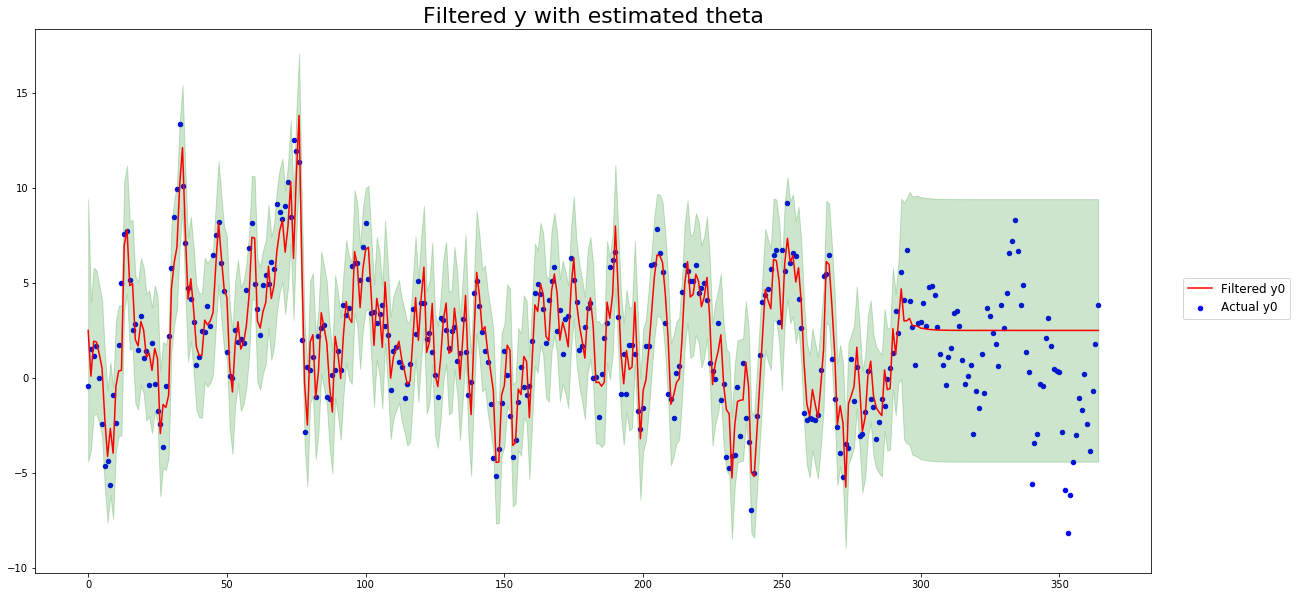

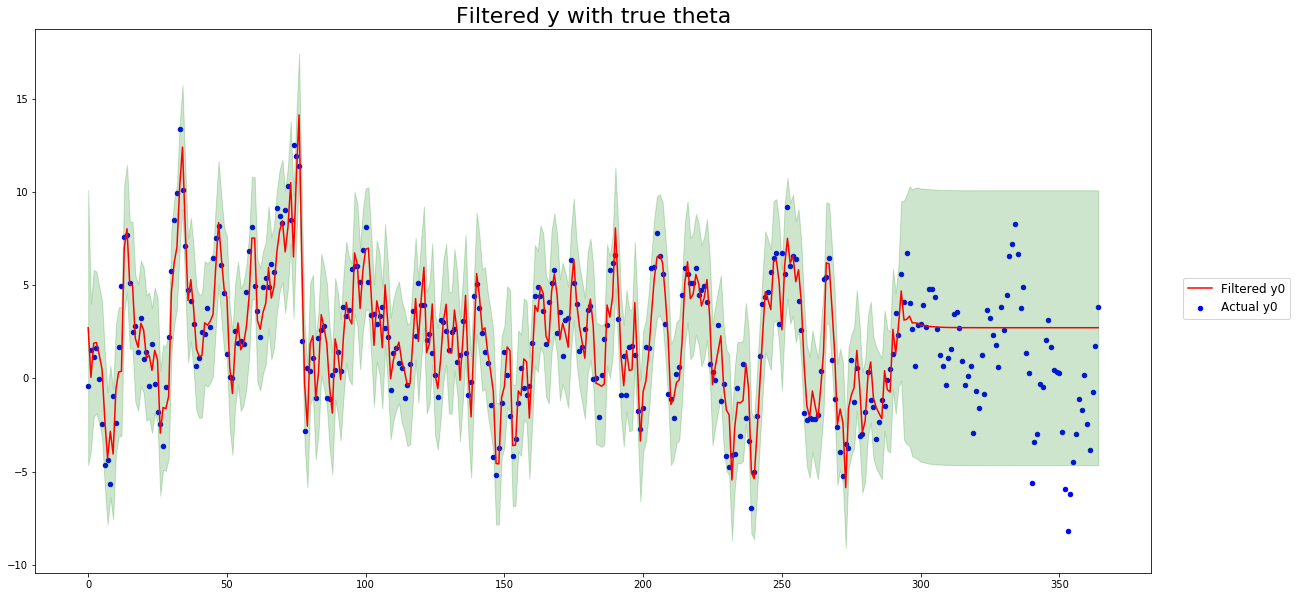

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')

The plot shows the predition using fitted theta and true theta are very similar. We can verify this by looking at some metrics. Overall, the fitted theta has very similar performance as the true theta in terms of RMSE. The mean_error is a more noisy metrics. 

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 1.672450005762641, 'mean_error': 0.00024338283983320783}
Ture theta for training data: {'RMSE': 1.6764521178531522, 'mean_error': 0.03503998291574311}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 1.6268683997435545, 'mean_error': 0.5101365658232868}
Ture theta for test data: {'RMSE': 1.6332455352555046, 'mean_error': 0.48946359749184276}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 3.2547662263650627, 'mean_error': 1.3612360175242686}
Ture theta for forecast data: {'RMSE': 3.259320403828818, 'mean_error': 1.5834075598421602}
